# Utilizando o banco de dados raspado do site: https://genealogy.math.ndsu.nodak.edu

O banco de dados é composto por três tabelas do SQLite, organizando as informações da seguinte forma:

- researchers: Armazena o ID e o nome de cada pesquisador.
- academic_titles: Registra os detalhes de cada título acadêmico, vinculando-os a um pesquisador por meio do seu ID.
- advisors_academic_titles: Mapeia a relação entre orientadores e títulos acadêmicos, que, por sua vez, estão associados a pesquisadores.

## Bibliotecas:

In [1]:
#!pip install faiss-cpu
#!pip install pyoperon
#!pip install gplearn

In [2]:
import sqlite3
import json
#import pickle   # Armazenar e carregar modelo treinado
#import faiss
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from dotenv import load_dotenv
from collections import defaultdict
from openai import OpenAI, ChatCompletion
from pyoperon.sklearn import SymbolicRegressor
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
#from getpass import getpass

# Carregar variáveis de ambiente do arquivo .env
load_dotenv()

# Caminho onde o banco está/será salvo
db_sqlite = "./data/mgp.sqlite"

## Objetos:

In [3]:
# Objeto pesquisador
class researcher:
  def __init__(self, researcher_id, name, academic_titles, descendants_id):
    self.researcher_id = researcher_id
    self.name = name
    self.academic_titles = academic_titles
    self.descendants_id = descendants_id

  def __str__(self):
    return f'{self.researcher_id} - {self.name} - {self.academic_titles} - {self.descendants_id}'

  def to_list(self):
    academic_titles_list = [academic_title.to_list() for academic_title in self.academic_titles]
    return [self.researcher_id, self.name, academic_titles_list, self.descendants_id]

  def save_to_db(self, db_sqlite):
    with sqlite3.connect(db_sqlite) as conn:
      cursor = conn.cursor()
      conn = sqlite3.connect(db_sqlite)
      cursor = conn.cursor()

      # Cria as tabelas se não existir
      cursor.execute('''
        CREATE TABLE IF NOT EXISTS researchers (
          researcher_id INTEGER PRIMARY KEY,
          name TEXT NOT NULL
        )
      ''')

      cursor.execute('''
        CREATE TABLE IF NOT EXISTS academic_titles (
          academic_title_id INTEGER PRIMARY KEY,
          researcher_id INTEGER NOT NULL,
          title TEXT NOT NULL,
          dissertation TEXT,
          institution TEXT,
          year INTEGER,
          country TEXT,
          FOREIGN KEY (researcher_id) REFERENCES researchers (researcher_id) ON DELETE CASCADE
        )
      ''')

      cursor.execute('''
        CREATE TABLE IF NOT EXISTS advisors_academic_titles (
          advisor_id INTEGER NOT NULL,
          academic_title_id INTEGER NOT NULL,
          PRIMARY KEY (advisor_id, academic_title_id),
          FOREIGN KEY (advisor_id) REFERENCES researchers (researcher_id) ON DELETE CASCADE,
          FOREIGN KEY (academic_title_id) REFERENCES academic_titles (academic_title_id) ON DELETE CASCADE
        )
      ''')

      # Inserindo os dados
      cursor.execute('''
        INSERT INTO researchers (researcher_id, name)
        VALUES (?, ?)
      ''', (self.researcher_id, self.name))

      for academic_title in self.academic_titles:
        cursor.execute('''
          INSERT INTO academic_titles (researcher_id, title, dissertation, institution, year, country)
          VALUES (?, ?, ?, ?, ?, ?)
        ''', (self.researcher_id, academic_title.title, academic_title.dissertation, academic_title.institution, academic_title.year, academic_title.country))
        academic_title_id = cursor.lastrowid
        if isinstance(academic_title.advisors_id, (list, tuple)):
          for advisor_id in academic_title.advisors_id:
            cursor.execute('''
              INSERT INTO advisors_academic_titles (advisor_id, academic_title_id)
              VALUES (?, ?)
            ''', (advisor_id, academic_title_id))

      conn.commit()

  def close_db(db_sqlite):
    conn = sqlite3.connect(db_sqlite)
    conn.close()

# Objeto título acadêmico
class academic_title:
  def __init__(self, title, dissertation, institution, year, country, advisors_id):
    self.title = title
    self.dissertation = dissertation
    self.institution = institution
    self.year = year
    self.country = country
    self.advisors_id = advisors_id

  def __str__(self):
    return f'{self.title} - {self.dissertation} - {self.institution} - {self.year} - {self.country} - {self.advisors_id}'

  def to_list(self):
    return [self.title, self.dissertation, self.institution, self.year, self.country, self.advisors_id]


class researcher_numeric_attributes:
  def __init__(self, researcher_dissertations, advisor_ids, student_ids):
    '''Retorna os atributos numéricos do pesquisador'''

    self.num_academic_titles = len(researcher_dissertations)
    self.first_year = min([diss[1] for diss in researcher_dissertations])
    self.last_year = max([diss[1] for diss in researcher_dissertations])
    self.num_advisors = len(advisor_ids)
    self.num_students = len(student_ids)
    self.average_years = average_between_years([diss[1] for diss in researcher_dissertations])

  def __str__(self):
    return f'{self.num_academic_titles} - {self.first_year} - {self.last_year} - {self.num_advisors} - {self.num_students} - {self.average_years}'

## Funções:

In [4]:
def search_db(db_sqlite, query, params=()):
  '''Essa função usa query e parâmetros para buscar no banco'''

  with sqlite3.connect(db_sqlite) as conn:
        cursor = conn.cursor()
        cursor.execute(query, params)

        return cursor.fetchall()


def generate_sql_query(user_query):
    '''Essa função usa IA para converter pergunta em SQL parametrizado.'''

    system_prompt = """Você é um assistente especializado em bancos de dados SQLite. Converta perguntas em SQL parametrizado usando `?` para os valores.

    Estrutura do banco que você é especialista:
    researchers (
      researcher_id INTEGER PRIMARY KEY,
      name TEXT NOT NULL
    )

    academic_titles (
      academic_title_id INTEGER PRIMARY KEY,
      researcher_id INTEGER NOT NULL,
      title TEXT NOT NULL,
      dissertation TEXT,
      institution TEXT,
      year INTEGER,
      country TEXT,
      FOREIGN KEY (researcher_id) REFERENCES researchers (researcher_id) ON DELETE CASCADE
    )

    advisors_academic_titles (
      advisor_id INTEGER NOT NULL,
      academic_title_id INTEGER NOT NULL,
      PRIMARY KEY (advisor_id, academic_title_id),
      FOREIGN KEY (advisor_id) REFERENCES researchers (researcher_id) ON DELETE CASCADE,
      FOREIGN KEY (academic_title_id) REFERENCES academic_titles (academic_title_id) ON DELETE CASCADE
    )

    Exemplo de saída correta:
    ['SELECT name FROM researchers WHERE researcher_id = ?', ['9', '22']]

    Retorne apenas a SQL e os valores em uma lista Python, sem explicações. Não inclua comandos DELETE ou UPDATE.
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_query}
        ]
    )

    return eval(response.choices[0].message.content.strip())


def get_advisor_and_student_ids(researcher_id):
  '''Essa função retorna a lista de orientadores e alunos de um pesquisador'''

  # Busca todos os orientadores (advisor_id) que estão associados a títulos acadêmicos pertencentes a um pesquisador específico (researcher_id).
  advisor_ids = search_db(db_sqlite,
                          "SELECT aat.advisor_id\
                           FROM advisors_academic_titles aat\
                           JOIN academic_titles at ON aat.academic_title_id = at.academic_title_id\
                           WHERE at.researcher_id = ?", (researcher_id,))

  # Busca os IDs dos pesquisadores que têm pelo menos um título acadêmico orientado pelo pesquisador especificado (researcher_id)
  student_ids = search_db(db_sqlite,
                          "SELECT r.researcher_id\
                           FROM researchers r\
                           JOIN academic_titles at ON r.researcher_id = at.researcher_id\
                           JOIN advisors_academic_titles aat ON at.academic_title_id = aat.academic_title_id\
                           WHERE aat.advisor_id = ?", (researcher_id,))

  # Corrige a lista
  advisor_ids = [row[0] for row in advisor_ids]
  student_ids = [row[0] for row in student_ids]

  return advisor_ids, student_ids

def list_to_id_and_name(list_id):
  '''Essa função retorna uma lista com ID e nome de uma lista de ID'''

  list_id_and_name = search_db(db_sqlite,
                                "SELECT researcher_id, name\
                                 FROM researchers\
                                 WHERE researcher_id IN ({})".format(",".join("?" * len(list_id))),
                                tuple(list_id))

  return list_id_and_name


def get_dissertations_researcher_son(db_sqlite, researcher_id):
  '''Retorna dissertações do pesquisador e de seus alunos'''
  with sqlite3.connect(db_sqlite) as conn:
      cursor = conn.cursor()

      # Dissertações e ano do próprio pesquisador
      cursor.execute('''
          SELECT dissertation, year FROM academic_titles
          WHERE researcher_id = ?
      ''', (researcher_id,))
      researcher_dissertations = [row for row in cursor.fetchall()]

      # Dissertações e ano da dissertações dos alunos (alunos desse pesquisador são os que têm ele como orientador)
      cursor.execute('''
          SELECT at.dissertation, year FROM academic_titles at
          JOIN advisors_academic_titles aat ON at.academic_title_id = aat.academic_title_id
          WHERE aat.advisor_id = ?
      ''', (researcher_id,))
      students_dissertations = [row for row in cursor.fetchall()]

  return researcher_dissertations, students_dissertations


def average_between_years(list_year):
  if len(list_year) > 1:
    return np.median([list_year[i] - list_year[i - 1] for i in range(1, len(list_year))])
  else:
    return 0


# Aplicando a transformação aos inputs categóricos
def transformar_inputs_categoricos(label_encoders, researcher_new):
    for col in ["academic_title", "institution", "country"]:
        researcher_new[col] = researcher_new[col].strip().lower().replace(" ", "")
        if researcher_new[col] in label_encoders[col].classes_:
            researcher_new[col] = int(label_encoders[col].transform([researcher_new[col]])[0])
        else:
            print(f"Aviso: '{researcher_new[col]}' não está nos dados de treinamento. Usando valor padrão -1.")
            researcher_new[col] = -1  # Valor para desconhecidos
    return researcher_new

## Consultas sem uso de ferramentas:

In [ ]:
# Busca toda a base de dados

df_all = pd.read_sql_query('''SELECT
                        r.researcher_id,
                        r.name AS researcher_name,
                        at.academic_title_id,
                        at.title AS academic_title,
                        at.dissertation,
                        at.institution,
                        at.year,
                        at.country,
                        GROUP_CONCAT(aat.advisor_id) AS advisor_ids  -- Lista os orientadores em uma única coluna
                    FROM academic_titles at
                    JOIN researchers r ON r.researcher_id = at.researcher_id
                    LEFT JOIN advisors_academic_titles aat ON at.academic_title_id = aat.academic_title_id
                    GROUP BY at.academic_title_id''', sqlite3.connect(db_sqlite))
sqlite3.connect(db_sqlite).close()

print("Banco sem otimização gerado pela raspagem:")
df_all.tail(10)

In [ ]:
# Busca orientadores e alunos de um pesquisador
researcher_id = 9#16

print(f'🔎 Buscando informações do pesquisador {researcher_id}...\n')
# Busca ID de todos os orientadores e alunos de um pesquisador
advisor_ids, student_ids = get_advisor_and_student_ids(researcher_id)


if advisor_ids:
    print(f'🎓 IDs dos orientadores encontrados: {advisor_ids}')

    # Busca o ID e o nome dos pesquisadores cujos researcher_id estão na lista de advisor_ids
    advisors = list_to_id_and_name(advisor_ids)
    print("📋 Lista de orientadores:")
    for advisor_id, advisor_name in advisors:
        print(f'🔹 ID: {advisor_id}, Nome: {advisor_name}')
else:
    print("❌ Nenhum orientador encontrado.")


print("\n" + "="*50 + "\n")   # Passa uma linha no terminal


if student_ids:
    print(f'🎓 IDs dos alunos encontrados: {student_ids}')

    # Busca os nomes e IDs dos pesquisadores cujos IDs estão na lista student_ids.
    students = list_to_id_and_name(student_ids)
    print("📋 Lista de alunos:")
    for student_id, student_name in students:
        print(f'🔹 ID: {student_id}, Nome: {student_name}')
else:
    print("❌ Nenhum aluno encontrado.")

In [ ]:
# Busca dissertações do pesquisador e de seus alunos
researcher_dissertations, students_dissertations = get_dissertations_researcher_son(db_sqlite, researcher_id)

print("Dissertações do pesquisador:",[diss[0] for diss in researcher_dissertations])
print("Dissertações dos alunos:", [diss[0] for diss in students_dissertations])

In [ ]:
print('Atributos númericos\n')
researcher_attributes = researcher_numeric_attributes(researcher_dissertations, advisor_ids, student_ids)

print(
      'Número de títulos acadêmicos:', researcher_attributes.num_academic_titles,
      '\nAno do primeiro e do último título:', researcher_attributes.first_year, 'e', researcher_attributes.last_year,
      '\nNúmero de orientadores:', researcher_attributes.num_advisors,
      '\nNúmero de alunos orientados:', researcher_attributes.num_students,
      '\nTempo médio entre seus títulos:', researcher_attributes.average_years,
      '\n\n',
      '\bTotal de pesquisadores:', search_db(db_sqlite, 'SELECT COUNT(*) FROM researchers')[0][0],
      '\nTotal de orientadores:', search_db(db_sqlite, 'SELECT COUNT(DISTINCT advisor_id) FROM advisors_academic_titles')[0][0],
      '\nTotal de não orientadores:', search_db(db_sqlite, 'SELECT COUNT(*) FROM researchers WHERE researcher_id NOT IN (SELECT advisor_id FROM advisors_academic_titles)')[0][0],
      )

# Utilizando inteligência artificial (Não implementado):

In [ ]:
# Pedir a chave sem exibi-la
#os.environ["OPENAI_API_KEY"] = getpass("Digite sua chave de API: ")

In [ ]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def chatbot(user_query):
    sql_data = generate_sql_query(user_query)
    print("🔍 Query gerada:", sql_data)

    try:
        results = search_db(db_sqlite, sql_data[0], sql_data[1])
        if results:
            return results
        return "Nenhum resultado encontrado."
    except Exception as e:
        return f"Erro ao executar a query: {e}"

# Testando
user_input = "Qual o total são orientadores"
print(chatbot(user_input))

# Utilizando Regressão Simbólica (PyOperon)

In [ ]:
### Mostrando o banco otimizado com colunas de irmãos acadêmicos e geração

df_optimized = pd.read_feather("./data/mgp_optimized.feather")

print("Mostrando banco otimizado. Colunas com listas python corrigida, e colunas de irmãos acadêmicos e geração geradas:")
df_optimized[256:261]

Banco otimizado corrigindo listas python, e adicionando colunas de irmão acadêmicos e geração:


,researcher_id,researcher_name,academic_title_id,academic_title,dissertation,institution,year,country,advisor_ids,num_advisors,num_students,num_siblings,generation
256,258,Dio Lewis Holl,257,Ph.D.,Viscous Fluid Motion in Eccentric Cylinders,The University of Chicago,1925.0,UnitedStates,[38464],1,12,2,5
257,259,Roger Henry Homer,258,Ph.D.,Abstract Extension Theory of Operators in Bana...,"University of California, Berkeley",1959.0,UnitedStates,[32846],1,3,23,13
258,260,Dean L. Isaacson,259,Ph.D.,None,University of Minnesota - Twin Cities,1968.0,UnitedStates,[],0,2,0,0
259,261,Elgin Harold Johnston,260,Ph.D.,Growth of Derivatives of Approximations to Ana...,University of Illinois at Urbana-Champaign,1977.0,UnitedStates,[4603],1,3,5,14
260,262,Fritz Keinert,261,Ph.D.,The Divergent K-Plane Transform,Oregon State University,1985.0,UnitedStates,[8230],1,5,4,29


In [ ]:
### Configurando e tratando os dados do banco

df_optimized = pd.read_feather("./data/mgp_optimized.feather")

# Definindo as colunas relevantes para prever o número de alunos
features = ["academic_title", "institution", "year", "country", "num_advisors", "num_siblings", "generation"]
target = "num_students"
print("Dados usados para predizer o número de alunos de um orientador:\n", features)

#df_optimized = df_optimized.head(300)

# Remover valores nulos e se quiser valores com zero
print("Tamanho do banco com valores nulos:", len(df_optimized))
numeric_columns = df_optimized.select_dtypes(include=['number']).columns
df_optimized = df_optimized.dropna(subset=numeric_columns)
df_optimized = df_optimized[(df_optimized[numeric_columns] >= 0).all(axis=1)]   # Colocar 1 aqui se quiser remover os valores zero
print("Novo tamanho do banco sem valores nulos:", len(df_optimized))

Tamanho do banco com valores nulos: 314703
Novo tamanho do banco sem valores nulos: 305641


## Existe uma relação entre o número de alunos orientados por um pesquisador e características como instituição, país, ano do título e número de orientadores?

### Usar expressões sem realizar o fit novamente:

In [ ]:
### Usando expressões salvas
# Carregar encoders dos dados categóricos
label_encoders_local = joblib.load('./data/label_encoders_fit_com_todos_features.pkl')

# Função para avaliar a expressão com novos dados
def predict_com_expressao_local(X1, X2, X3, X4, X5, X6, X7, expression):
    variables = {
        'X1': X1, 'X2': X2, 'X3': X3, 
        'X4': X4, 'X5': X5, 'X6': X6, 'X7': X7
    }
    print()
    return eval(expression, {}, variables)

fit_com_todos_features = "(19.380669 + (0.007762 * (((((-0.311229) * X7) * ((-0.352297) * X7)) + (((((-0.065656) * X1) + ((((-0.193251) * X7) * (((-0.083417) * X7) * ((-0.083417) * X7))) * (((-0.083417) * X7) * ((-0.083417) * X7)))) - (((-2.614913) * X5) * ((-2.250102) * X5))) - (((-6.825504) * X1) / (0.156066 * X3)))) - (((-7.526910) * X5) - ((((((-1.185517) * X3) + (2.424742 * X6)) + ((((-0.311229) * X7) * ((-0.352297) * X7)) + ((((-0.083417) * X7) * ((-0.083417) * X7)) * (((-0.083417) * X7) * ((-0.083417) * X7))))) - (((-0.083417) * X6) * ((-0.083417) * X6))) - (((-0.070440) * X6) * ((-0.083417) * X6)))))))"  # (sua expressão completa)
expression_fit_select = fit_com_todos_features

# Exemplo de uso:
dados_novo_pesquisador = {
    "academic_title": "Ph.D.",
    "institution": "Iowa State University",
    "year": 1975,
    "country": "United States",
    "num_advisors": 2,
    "num_siblings": 98,
    "generation": 31
    }

researcher_new = transformar_inputs_categoricos(label_encoders_local, dados_novo_pesquisador)
print("Dados de entrada:", researcher_new)
researcher_fortran = np.asfortranarray([[researcher_new[col] for col in features]], dtype=np.float64)

prediction = predict_com_expressao_local(768, 1073, 1975, 126, 2, 98, 31, expression_fit_select)  # Valores na ordem das features originais

print("Pesquisador exemplo deve ter:", max(1, round(prediction)), "aluno(s)")

### Encontrando a expressão por meio da regressão símbolica

In [7]:
### Codificar variáveis categóricas
label_encoders = {}
for col in ["academic_title", "institution", "country"]:
    le = LabelEncoder()
    df_optimized[col] = le.fit_transform(df_optimized[col].str.strip().str.lower().str.replace(" ", ""))
    label_encoders[col] = le

### Normalizar valores numéricos
#scaler = MinMaxScaler()
#df_optimized[features] = scaler.fit_transform(df_optimized[features])

### Converter em Fortran-order
features_df = np.asfortranarray(df_optimized[features].values, dtype=np.float64)
target_df = np.asfortranarray(df_optimized[target].values, dtype=np.float64)

# Criar o regressor simbólico
model = SymbolicRegressor(
    n_threads=32
)

### Treinar o modelo com os dados
#model.fit(df_optimized[features], df_optimized[target])
model.fit(features_df, target_df)

## Exibir o melhor modelo encontrado
print("Melhor expressão encontrado:\n", model.pareto_front_[0]['model'], "\n")

Melhor expressão encontrado:
 (19.200710 + ((-0.020754) * ((((0.435386 * X3) + ((-0.510987) * X6)) + (((0.080738 * X7) * (0.055555 * X7)) * (((((0.055555 * X7) * (0.055555 * X7)) * (0.055555 * X7)) * (0.055555 * X7)) * (0.055555 * X7)))) + (((1.772454 * X1) - ((((0.080738 * X7) * (0.055555 * X7)) * (0.055555 * X7)) * ((0.434294 * X3) + (7.738910 * X6)))) / ((((0.402473 * X3) + (0.263522 * X6)) / (-1.673375)) + (((0.293425 * X3) + ((-0.510987) * X6)) + (((0.318310 * X6) + (0.497090 - ((-1.451398) * X5))) * (((0.055555 * X7) * (0.055555 * X7)) * (0.055555 * X7))))))))) 



In [ ]:
# Salvar os encoders
joblib.dump(label_encoders, './data/label_encoders.pkl')
print("label_encoders desse treinamento salvo localmente.")

In [8]:
### Fazer previsões
df_optimized["predicted_students"] = model.predict(np.asfortranarray(df_optimized[features].values, dtype=np.float64))

### Visualizar algumas previsões
print(df_optimized[[target, "predicted_students"]].head(20))

### Calcular o erro absoluto
mae = mean_absolute_error(df_optimized[target], df_optimized["predicted_students"])
print("\nErro médio absoluto:", mae)

    num_students  predicted_students
0              3            1.564585
1              0            1.537970
2              0            1.511351
3              2            1.417974
4              0            1.484732
5              0            1.458111
6              8            1.767519
7              0            1.431488
8              5            1.758602
9              0            1.422613
10             0            1.348528
11             0            1.413738
12            16            1.413738
13             0            1.612253
14             0            1.740770
15            21            1.603329
16             0            1.740770
17             0            1.404863
18             0            1.411814
19             0            1.395988

Erro médio absoluto: 1.7550981044769287


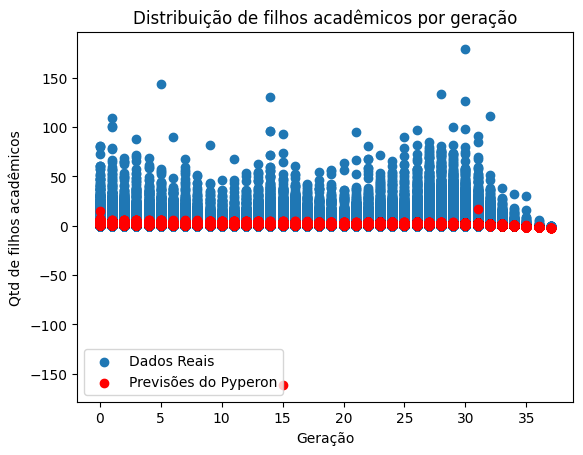

In [9]:
# Visualizar os resultados
plt.scatter(df_optimized["generation"], df_optimized[target], label='Dados Reais')
plt.scatter(df_optimized["generation"], df_optimized["predicted_students"], color='red', label='Previsões do Pyperon')
plt.xlabel('Geração')
plt.ylabel('Qtd de filhos acadêmicos')
plt.legend()
plt.title('Distribuição de filhos acadêmicos por geração')
plt.show()

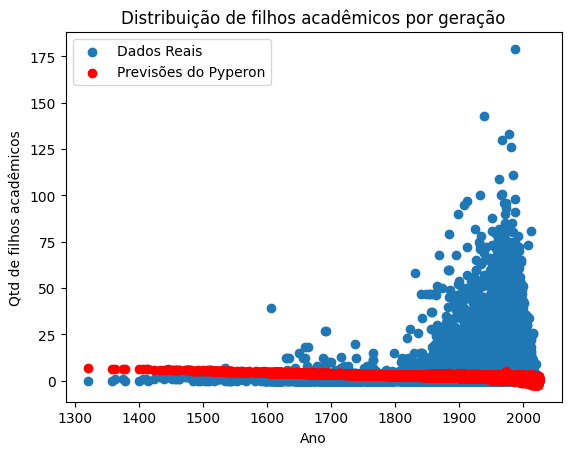

In [10]:
# Visualizar os resultados
mask = (df_optimized["year"] > 500) & (df_optimized["year"] < 2100)
plt.scatter(df_optimized["year"][mask], df_optimized[target][mask], label='Dados Reais')
plt.scatter(df_optimized["year"][mask], df_optimized["predicted_students"][mask], color='red', label='Previsões do Pyperon')
plt.xlabel('Ano')
plt.ylabel('Qtd de filhos acadêmicos')
plt.legend()
plt.title('Distribuição de filhos acadêmicos por geração')
plt.show()

In [11]:
print("Predição com mais alunos:\n\n", df_optimized[['researcher_id'] + [f for f in features if f not in ['year']] + ["predicted_students"]].nlargest(10, "predicted_students").to_string(index=False))

Predição com mais alunos:

  researcher_id  academic_title  institution  country  num_advisors  num_siblings  generation  predicted_students
        261324             768         1868        4             2            36          31           16.869444
        290124             768         1555       57             0             0           0           14.719328
        298240             909         3190      125             0             0           0            6.785710
        179836             707         3870       40             0             0           0            6.567831
        127264             707         3870       40             1             0           0            6.523979
        164338              18         3459       55             0             0           0            6.432988
        179837             671          303       31             0             0           0            6.410528
        127264             856         3870       40             0  

In [12]:
comparar_ids = [1, 4, 93526, 261324, 17394]
resultado_comparacao = df_optimized[df_optimized['researcher_id'].isin(comparar_ids)]
print(resultado_comparacao.to_string(index=False))

 researcher_id             researcher_name  academic_title_id  academic_title                                                                        dissertation  institution   year  country     advisor_ids  num_advisors  num_students  num_siblings  generation  predicted_students
             1     Ernest Willard Anderson                  1             768       Statics of Special Types of Homogeneous Elastic Slabs with Variable Thickness         1073 1933.0      126           [258]             1             3            11           6            1.564585
             4       Charles Joseph Thorne                  4             768 The Approximate Solution of Linear Differential Equations by the Use of Functionals         1073 1941.0      126           [239]             1             2             1           8            1.417974
         17394            Hans Freudenthal              17396             432                                      Über die Enden topologischer Räume und Gru

In [13]:
# Perguntar sobre um novo pesquisador
dados_novo_pesquisador = {
    "academic_title": "Ph.D.",
    "institution": "Iowa State University",
    "year": 1975,
    "country": "United States",
    "num_advisors": 2,
    "num_siblings": 98,
    "generation": 31
    }

researcher_new = transformar_inputs_categoricos(label_encoders, dados_novo_pesquisador)

print("Dados de entrada:", researcher_new)
researcher_fortran = np.asfortranarray([[researcher_new[col] for col in features]], dtype=np.float64)

print("Pesquisador exemplo deve ter:", max(1, round(model.predict(researcher_fortran)[0])), "aluno(s)")

Dados de entrada: {'academic_title': 768, 'institution': 1073, 'year': 1975, 'country': 126, 'num_advisors': 2, 'num_siblings': 98, 'generation': 31}
Pesquisador exemplo deve ter: 2 aluno(s)


## É possível prever o orientador de um pesquisador com base na similaridade temática entre dissertações?

In [ ]:
# Criar embeddings dos orientadores
print("\n\nTamanho do banco com dissertações nulas:", len(df_optimized))
df_sem_nulos = df_optimized.dropna(subset=["dissertation"])
print("Novo tamanho do banco sem dissertações nulas:", len(df_sem_nulos))

print("\n\nVerificando dados do banco:\n")
comparar_ids = [1, 4, 94153]
resultado_comparacao = df_sem_nulos[df_sem_nulos['researcher_id'].isin(comparar_ids)]
print(resultado_comparacao.to_string(index=False))



Tamanho do banco com valores nulos: 305641
Novo tamanho do banco sem valores nulos: 289657


Verificando dados do banco:

 researcher_id         researcher_name  academic_title_id  academic_title                                                                        dissertation  institution   year  country advisor_ids  num_advisors  num_students  num_siblings  generation  predicted_students
             1 Ernest Willard Anderson                  1             768       Statics of Special Types of Homogeneous Elastic Slabs with Variable Thickness         1073 1933.0      126       [258]             1             3            11           6            1.564585
             4   Charles Joseph Thorne                  4             768 The Approximate Solution of Linear Differential Equations by the Use of Functionals         1073 1941.0      126       [239]             1             2             1           8            1.417974
         94153       Peter John Hurley              93494

In [15]:
# Carregar modelo BERT
bert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Criar embeddings dos orientadores
print("\n\nTamanho do banco com valores nulos:", len(df_optimized))
df_sem_nulos = df_optimized.dropna(subset=["dissertation"])
print("Novo tamanho do banco sem valores nulos:", len(df_sem_nulos))
orientadores_emb = {
    row["researcher_id"]: bert_model.encode(row["dissertation"])
    for _, row in tqdm(df_sem_nulos.iterrows(), desc="Gerando Embeddings", total=len(df_sem_nulos))
}

# Criar DataFrame de treinamento
dados = []
for nome, emb in orientadores_emb.items():
    features = emb  # Embedding BERT como features
    dados.append([nome, *features])

df_train = pd.DataFrame(dados, columns=["orientador"] + [f"feat_{i}" for i in range(len(features))])

# Criar similaridade como alvo (usamos o próprio cosseno como target para ensinar o modelo)
# Calcular similaridade apenas para pares necessários (diagonal)
similarities = []
embeddings = list(orientadores_emb.values())
for emb in tqdm(embeddings, desc="Calculando similaridades"):
    similarity = cosine_similarity([emb], [emb])[0, 0]  # Similaridade com ela mesma
    similarities.append(similarity)

df_train["similarity"] = similarities  # Similares com elas mesmas (idealmente, dados rotulados viriam de alunos reais)

# Treinar modelo de Regressão Simbólica
X = df_train.drop(columns=["orientador", "similarity"]).values  # Features (Embeddings)
y = df_train["similarity"].values  # Similaridade como target

model = SymbolicRegressor()

print("\n\nTreinamento iniciado...\n")
model.fit(X, y)
print("...treinamento finalizado.")

# Função para encontrar o melhor orientador para uma nova dissertação
def melhor_orientador(nova_dissertacao):
    nova_emb = bert_model.encode(nova_dissertacao).reshape(1, -1)  # Gerar embedding
    pred_sim = model.predict(nova_emb)[0]  # Calcular similaridade

    # Comparar com todos os orientadores
    melhor_nome = max(orientadores_emb.keys(), key=lambda nome: cosine_similarity([orientadores_emb[nome]], nova_emb)[0, 0])

    return melhor_nome, pred_sim



Tamanho do banco com valores nulos: 305641
Novo tamanho do banco sem valores nulos: 289657


Calculando similaridades: 100%|██████████| 288291/288291 [00:26<00:00, 11068.84it/s]




Treinamento iniciado...

...treinamento finalizado.


In [ ]:
print("Expressão definida para usar com as dissertações após o embeddings:\n", model.pareto_front_[0]['model'])

Expressão definida:
 (1.000000 + ((-0.000000) * ((((0.318310 * X83) + (((-1.678869) * X39) / (1.669846 * X269))) - ((1.267593 + (-2.185564)) / (((((0.295780 * X83) / (0.016648 * X297)) + (-2.133330)) * ((-0.913446) * X77)) * ((((2.718282 * X83) / (0.016648 * X297)) - (0.318310 / (0.506176 * X308))) + ((-1.426254) * X77))))) - (((((-1.509581) * X317) / (0.600713 * X280)) - (((0.318310 / (0.506176 * X308)) * ((-0.913446) * X77)) + (0.103551 / ((((0.295780 * X83) / (0.016648 * X297)) - (-1.350978)) * ((-0.913446) * X89))))) * (-1.350978)))))


In [19]:
#input_dissertacao = input("Digite a dissertação: ")
# Testando com uma nova dissertação
nova_dissertacao = "Using symbolic regression in predictions"
#nova_dissertacao = "Statical Equilibrium of Skew"
melhor, score = melhor_orientador(nova_dissertacao)

melhor_researcher = df_optimized.iloc[melhor]
#print(f"Melhor orientador para essa dissertação: {melhor_researcher} (similaridade: {score:.3f})")
print(f"🚀 Melhor orientador para essa dissertação 🚀\nID MGP: {melhor_researcher['researcher_id']}\nNome: {melhor_researcher['researcher_name']}\nDissertação: {melhor_researcher['dissertation']} (similaridade da predição: {score:.2%} | similaridade cosseno: {cosine_similarity(bert_model.encode(nova_dissertacao).reshape(1, -1), bert_model.encode(melhor_researcher['dissertation']).reshape(1, -1))[0, 0]:.2%})\nAno do título título acadêmico do orientador: {melhor_researcher['year']}")

🚀 Melhor orientador para essa dissertação 🚀
ID MGP: 94153
Nome: Peter John Hurley
Dissertação: Lagrangian Plume Modelling During the Morning Transition Period (similaridade da predição: 100.00% | similaridade cosseno: 7.56%)
Ano do título título acadêmico do orientador: 1991.0


## Qual é o grau de similaridade temática entre a dissertação de um pesquisador e a de seus alunos?

In [40]:
### Gerando a lista de alunos dos orientadores

alunos_map = defaultdict(list)

for _, row in df_optimized.iterrows():
    aluno_id = row["researcher_id"]
    orientadores = row["advisor_ids"]

    if isinstance(orientadores, str):  # Caso esteja como string
        orientadores = [int(o.strip()) for o in orientadores.split(",") if o.strip().isdigit()]
    
    for orientador_id in orientadores:
        alunos_map[orientador_id].append(aluno_id)
print(alunos_map['17394'])

[16976, 17395, 22100, 44049, 45240, 46552, 46988, 49656, 49657, 51034, 51397, 75834, 86448, 88706, 102368, 102369, 102370, 102371, 102372, 103914, 126023, 126024, 126201, 144637, 144638, 145182, 296308]


In [41]:
def similaridade_com_alunos(orientador_id):
    orientador_id = str(orientador_id)  # 🔁 converte para string para acessar alunos_map
    
    if int(orientador_id) not in df_optimized["researcher_id"].values:
        print("ID de orientador não encontrado.")
        return []

    orientador_row = df_optimized[df_optimized["researcher_id"] == int(orientador_id)].iloc[0]
    dissert_orientador = orientador_row["dissertation"]

    if pd.isna(dissert_orientador):
        print("Dissertação do orientador ausente.")
        return []

    emb_orientador = bert_model.encode(dissert_orientador).reshape(1, -1)

    orientandos_ids = alunos_map.get(orientador_id, [])
    if not orientandos_ids:
        print("Este orientador não possui alunos registrados.")
        return []

    resultados = []
    for aluno_id in orientandos_ids:
        aluno_row = df_optimized[df_optimized["researcher_id"] == aluno_id]
        if aluno_row.empty:
            continue

        aluno_row = aluno_row.iloc[0]
        dissert_aluno = aluno_row["dissertation"]

        if pd.isna(dissert_aluno):
            continue

        emb_aluno = bert_model.encode(dissert_aluno).reshape(1, -1)
        sim_cos = cosine_similarity(emb_orientador, emb_aluno)[0, 0]
        sim_pred = model.predict(emb_aluno)[0]

        resultados.append({
            "aluno_id": aluno_id,
            "aluno_nome": aluno_row["researcher_name"],
            "ano_aluno": aluno_row["year"],
            "similaridade_cosseno": sim_cos,
            "similaridade_prevista": sim_pred
        })

    return sorted(resultados, key=lambda x: x["similaridade_cosseno"], reverse=True)


In [48]:
resultados = similaridade_com_alunos(orientador_id=17394)

# Exibe os resultados individuais
for r in resultados:
    print(f"\n👨‍🎓 Aluno: {r['aluno_nome']} ({r['aluno_id']}) - Ano: {r['ano_aluno']}")
    print(f"  - Similaridade cosseno: {r['similaridade_cosseno']:.2%}")
    print(f"  - Similaridade prevista: {r['similaridade_prevista']:.2%}")

# Calcula e exibe as médias, se houver resultados
if resultados:
    media_cosseno = sum(r["similaridade_cosseno"] for r in resultados) / len(resultados)
    media_prevista = sum(r["similaridade_prevista"] for r in resultados) / len(resultados)

    print(f"\n📊 Média de similaridade cosseno: {media_cosseno:.2%}")
    print(f"📊 Média de similaridade prevista: {media_prevista:.2%}")
else:
    print("\nNenhum aluno com dissertação encontrada para calcular média.")



👨‍🎓 Aluno: Arie Hendrik Boers (51397) - Ano: 1956.0
  - Similaridade cosseno: 41.70%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: P. M. van Hiele (102372) - Ano: 1957.0
  - Similaridade cosseno: 32.98%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Nicole Leonie Jean Marie De Grande-De Kimpe (103914) - Ano: 1970.0
  - Similaridade cosseno: 27.79%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Fred Goffree (296308) - Ano: 1979.0
  - Similaridade cosseno: 27.19%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Eduard Johannes van der Waag (102368) - Ano: 1952.0
  - Similaridade cosseno: 25.59%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: G. J. B. Bremer (102370) - Ano: 1955.0
  - Similaridade cosseno: 25.49%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Willem Titus van Est (22100) - Ano: 1950.0
  - Similaridade cosseno: 23.69%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Adrie Treffers (126201) - Ano: 1978.0
  - Similaridade cosseno: 19.57%
  - Similaridade prevista: 100.00%

👨‍🎓 

In [49]:
resultados = similaridade_com_alunos(orientador_id=9)

# Exibe os resultados individuais
for r in resultados:
    print(f"\n👨‍🎓 Aluno: {r['aluno_nome']} ({r['aluno_id']}) - Ano: {r['ano_aluno']}")
    print(f"  - Similaridade cosseno: {r['similaridade_cosseno']:.2%}")
    print(f"  - Similaridade prevista: {r['similaridade_prevista']:.2%}")

# Calcula e exibe as médias, se houver resultados
if resultados:
    media_cosseno = sum(r["similaridade_cosseno"] for r in resultados) / len(resultados)
    media_prevista = sum(r["similaridade_prevista"] for r in resultados) / len(resultados)

    print(f"\n📊 Média de similaridade cosseno: {media_cosseno:.2%}")
    print(f"📊 Média de similaridade prevista: {media_prevista:.2%}")
else:
    print("\nNenhum aluno com dissertação encontrada para calcular média.")



👨‍🎓 Aluno: Leslie D. Gates, Jr. (23) - Ano: 1952.0
  - Similaridade cosseno: 38.55%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Edward Martin Riseman (101996) - Ano: 1969.0
  - Similaridade cosseno: 5.92%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Wayne Allen Muth (71) - Ano: 1963.0
  - Similaridade cosseno: -1.63%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Henry Francis Hrubecky (28) - Ano: 1953.0
  - Similaridade cosseno: -1.97%
  - Similaridade prevista: 100.00%

👨‍🎓 Aluno: Steven Duane Woods (87826) - Ano: 1982.0
  - Similaridade cosseno: -3.50%
  - Similaridade prevista: 100.00%

📊 Média de similaridade cosseno: 7.47%
📊 Média de similaridade prevista: 100.00%


In [ ]:
df_optimized

In [ ]:
#FIM